# DM - Data preparation [TASK 1.2]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset
from utils import build_grid_plot
from utils.validators import check_int, MIN_DATE, MAX_DATE

import os
import sys
import logging as lg
import string

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

nb_workers = int(os.cpu_count() / 2 + 1)
pandarallel.initialize(
    progress_bar=True,
    nb_workers=nb_workers,
)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Fetching the dataset using our native python functions.

In [2]:
# Load the pickles
dataset = fetch_preprocessed_dataset(step_name="outlier_detection")
tweets = dataset['tweets.pickle']
users = dataset['users.pickle']

Before aggregating users and tweets dataset we should be clean user_id column from invalid values.

In [3]:
tweets = tweets[tweets['user_id'].parallel_map(check_int)]
tweets = tweets.astype({'user_id': 'int64'})

tweets.info()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10052836 entries, 0 to 13664695
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   float64       
 2   reply_count     float64       
 3   favorite_count  float64       
 4   num_hashtags    float64       
 5   num_urls        float64       
 6   num_mentions    float64       
 7   created_at      datetime64[ns]
 8   text            string        
dtypes: datetime64[ns](1), float64(6), int64(1), string(1)
memory usage: 767.0 MB


## Data aggregation

Aggregation of `tweet_num`, so the number of tweets for each user.

In [4]:
column_name = 'tweets_num' 
tweets_grouped_by_users = tweets.groupby(['user_id']).size()

users = users.merge(tweets_grouped_by_users.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    11508.000000
mean       873.516597
std       1142.250366
min          1.000000
25%         59.750000
50%        121.000000
75%       1582.250000
max       3926.000000
Name: tweets_num, dtype: float64

Now is created another attribute called `tweets_2020_num` that represents the number of tweets of each users pulished in the year 2020.

In [5]:
column_name = 'tweets_2020_num'

def filter_datetime_2020(datetime):
    return MIN_DATE <= pd.Timestamp(datetime) < MAX_DATE

tweets_filtered_2020 = tweets[tweets['created_at'].parallel_map(filter_datetime_2020)]
tweets_grouped_2020 = tweets_filtered_2020.groupby(['user_id']).size()

users = users.merge(tweets_grouped_2020.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean       865.112096
std       1128.659294
min          1.000000
25%         59.000000
50%        121.000000
75%       1567.000000
max       3467.000000
Name: tweets_2020_num, dtype: float64

Total number of likes per user added in column `likes_num`.

In [6]:
column_name = 'likes_num'
tweets_grouped_likes = tweets.groupby(['user_id'])['favorite_count'].sum()

users = users.merge(tweets_grouped_likes.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count     11508.000000
mean       1234.076382
std       21344.947342
min           0.000000
25%           3.000000
50%           9.000000
75%         365.000000
max      868163.000000
Name: likes_num, dtype: float64

This new column `comments_num` represents for each user the total number of comments that he wrotes.

In [7]:
column_name = 'comments_num'
tweets_grouped_comments = tweets.groupby(['user_id'])['reply_count'].sum()

users = users.merge(tweets_grouped_comments.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    11508.000000
mean        56.104970
std        521.967526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10273.000000
Name: comments_num, dtype: float64

`ratio_likes_x_tweets` represent the number of likes for each tweet. 

In [8]:
column_name = 'ratio_likes_x_tweets'

users[column_name] = users['likes_num'] / users['tweets_num']
users[column_name].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

users[column_name].describe()

count    11508.000000
mean         3.104821
std         33.290367
min          0.000000
25%          0.024768
50%          0.066146
75%          0.268293
max       1454.209380
Name: ratio_likes_x_tweets, dtype: float64

The entropy of user is accounted by `entropy` column computed on number of tweets done a user on total number of tweets.

In [9]:
column_name = 'entropy'
p_user_tweets = users['tweets_num'] / len(tweets)
users[column_name] = - (p_user_tweets * np.log2(p_user_tweets))

users[column_name].describe()

count    11508.000000
mean         0.001071
std          0.001324
min          0.000002
25%          0.000103
50%          0.000197
75%          0.001988
max          0.004422
Name: entropy, dtype: float64

Here is aggregated the mean of texts length for each user by the new column `texts_mean_length`.

In [10]:
column_name = 'texts_mean_length'
tweets[column_name] = tweets['text'].parallel_map(lambda t: len(t))
tweets_grouped_text_length = tweets.groupby(['user_id'])[column_name].mean()

users = users.merge(tweets_grouped_text_length.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean        70.273139
std         16.636644
min          3.000000
25%         61.516377
50%         67.494258
75%         79.642466
max        245.000000
Name: texts_mean_length, dtype: float64

`texts_special_chars_length` represents the mean number of special character inside texts for each user.

In [11]:
column_name = 'texts_special_chars_length'
VALID_CHARACTERS = string.ascii_letters + string.digits + " " + "\n"

def count_special_chars(text):
    count = 0
    for ch in text:
        count += 0 if ch in VALID_CHARACTERS else 1
    return count

tweets[column_name] = tweets['text'].parallel_map(count_special_chars)
tweets_grouped_text_sc_length = tweets.groupby(['user_id'])[column_name].mean()

users = users.merge(tweets_grouped_text_sc_length.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean         7.324552
std         12.005750
min          0.000000
25%          3.829188
50%          4.766878
75%          6.489471
max        215.000000
Name: texts_special_chars_length, dtype: float64

## Data description

Description of users columns statistichs.

In [12]:
users.describe()

,id,statuses_count,tweets_num,tweets_2020_num,likes_num,comments_num,ratio_likes_x_tweets,entropy,texts_mean_length,texts_special_chars_length
count,1.150800e+04,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,1.274517e+09,5681.686566,873.516597,865.112096,1234.076382,56.104970,3.104821,0.001071,70.273139,7.324552
std,9.354135e+08,18769.594489,1142.250366,1128.659294,21344.947342,521.967526,33.290367,0.001324,16.636644,12.005750
min,6.780330e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000002,3.000000,0.000000
25%,4.663594e+08,42.000000,59.750000,59.000000,3.000000,0.000000,0.024768,0.000103,61.516377,3.829188
50%,1.128643e+09,68.000000,121.000000,121.000000,9.000000,0.000000,0.066146,0.000197,67.494258,4.766878
75%,2.357148e+09,2520.250000,1582.250000,1567.000000,365.000000,0.000000,0.268293,0.001988,79.642466,6.489471
max,3.164942e+09,399555.000000,3926.000000,3467.000000,868163.000000,10273.000000,1454.209380,0.004422,245.000000,215.000000


Following line of code shows first users dataset rows.

In [13]:
users.head()

,id,name,lang,bot,created_at,statuses_count,tweets_num,tweets_2020_num,likes_num,comments_num,ratio_likes_x_tweets,entropy,texts_mean_length,texts_special_chars_length
0,2353593986,Lamonica Raborn,en,True,2019-02-22 18:00:42,76,118,118,5.0,0.0,0.042373,0.000192,63.423729,4.076271
1,2358850842,Lourie Botton,en,False,2019-02-26 03:02:32,54,104,104,6.0,0.0,0.057692,0.000171,69.961538,3.663462
2,137959629,Dadan Syarifudin,en,True,2015-04-30 07:09:56,3,3,3,0.0,0.0,0.000000,0.000006,17.333333,4.333333
3,466124818,Carletto Focia,it,True,2017-01-18 02:49:18,50,1253,1253,240.0,0.0,0.191540,0.001617,89.628891,5.734238
4,2571493866,MBK Ebook,en,False,2019-06-18 19:30:21,7085,3217,3217,207.0,0.0,0.064346,0.003715,74.583152,3.718993


## Distribution analysis

Users histograms of new values to show their distribution.

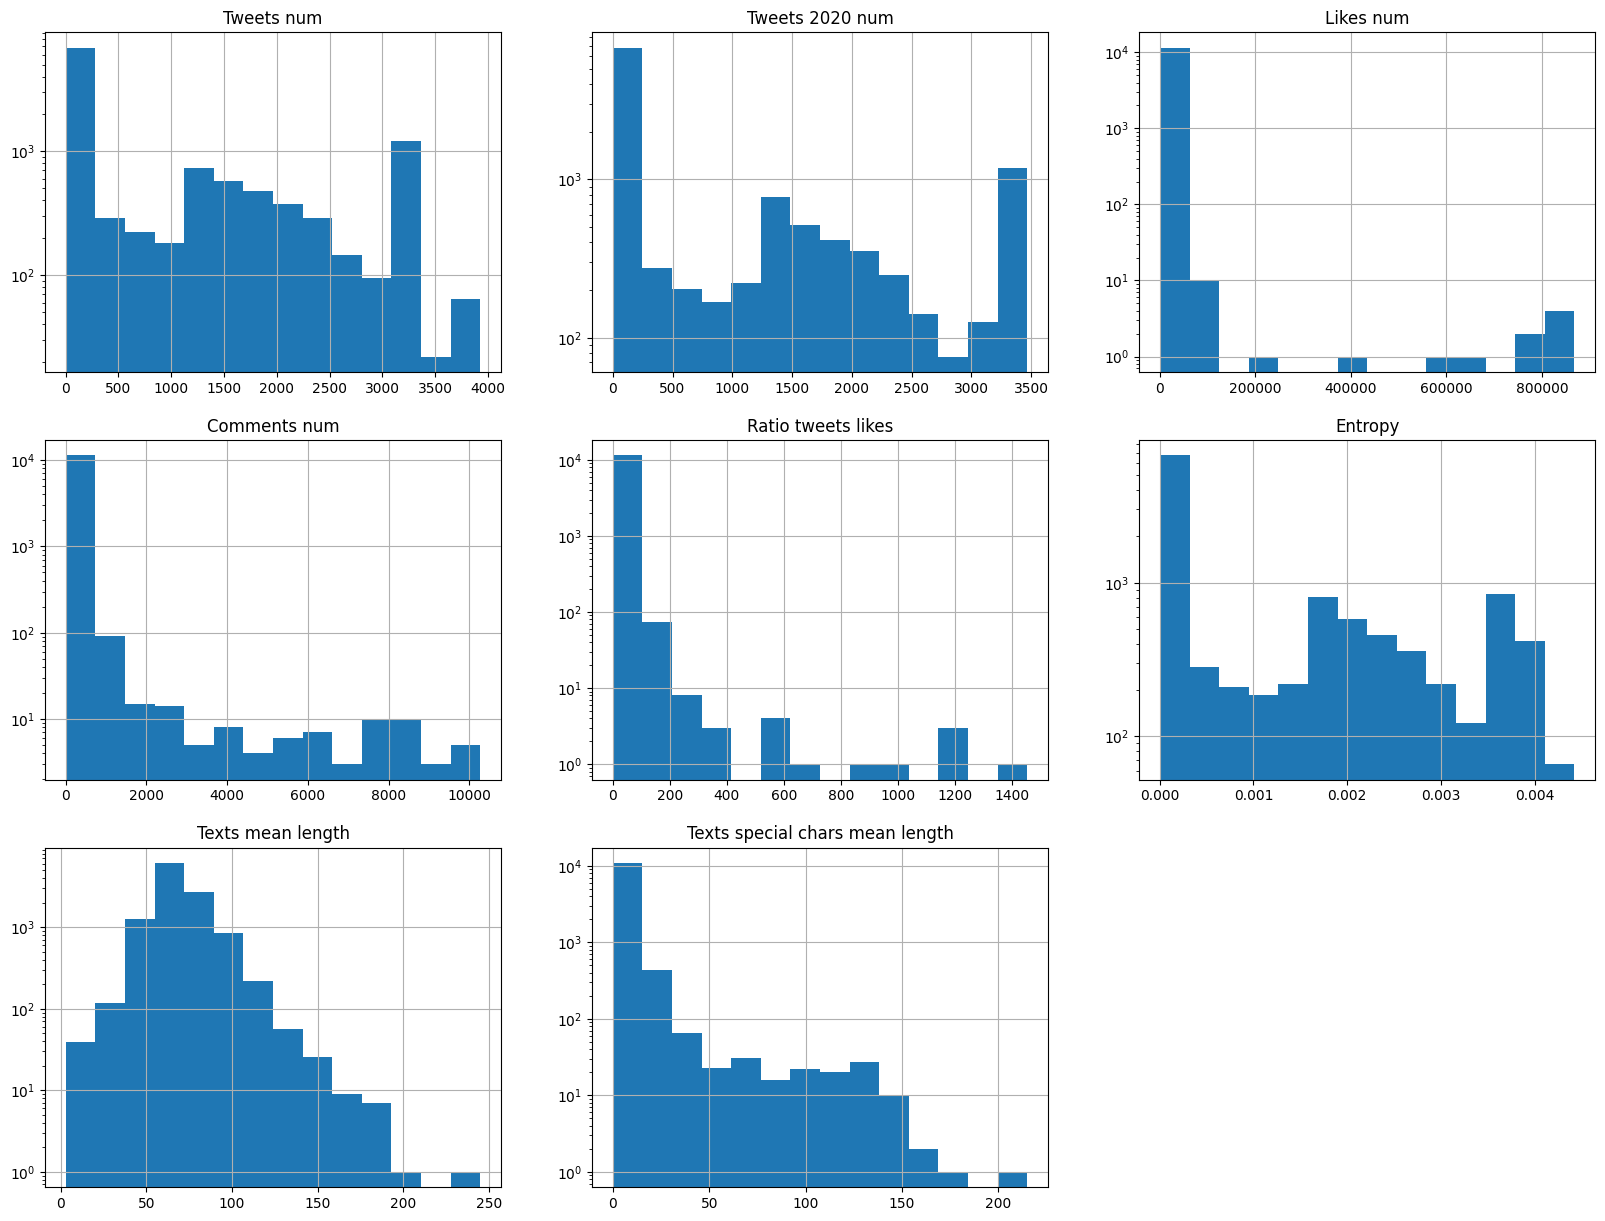

In [14]:
configs = [
    {
        'type': 'hist',
        'column': users['tweets_num'],
        'title': 'Tweets num',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['tweets_2020_num'],
        'title': 'Tweets 2020 num',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['likes_num'],
        'title': 'Likes num',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['comments_num'],
        'title': 'Comments num',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['ratio_likes_x_tweets'],
        'title': 'Ratio tweets likes',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['entropy'],
        'title': 'Entropy',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['texts_mean_length'],
        'title': 'Texts mean length',
        'yscale': 'log',
    },
    {
        'type': 'hist',
        'column': users['texts_special_chars_length'],
        'title': 'Texts special chars mean length',
        'yscale': 'log',
    },
]

build_grid_plot(configs=configs)

### Outliers detection

Box-plots that shows new aggregated attributes outliers.

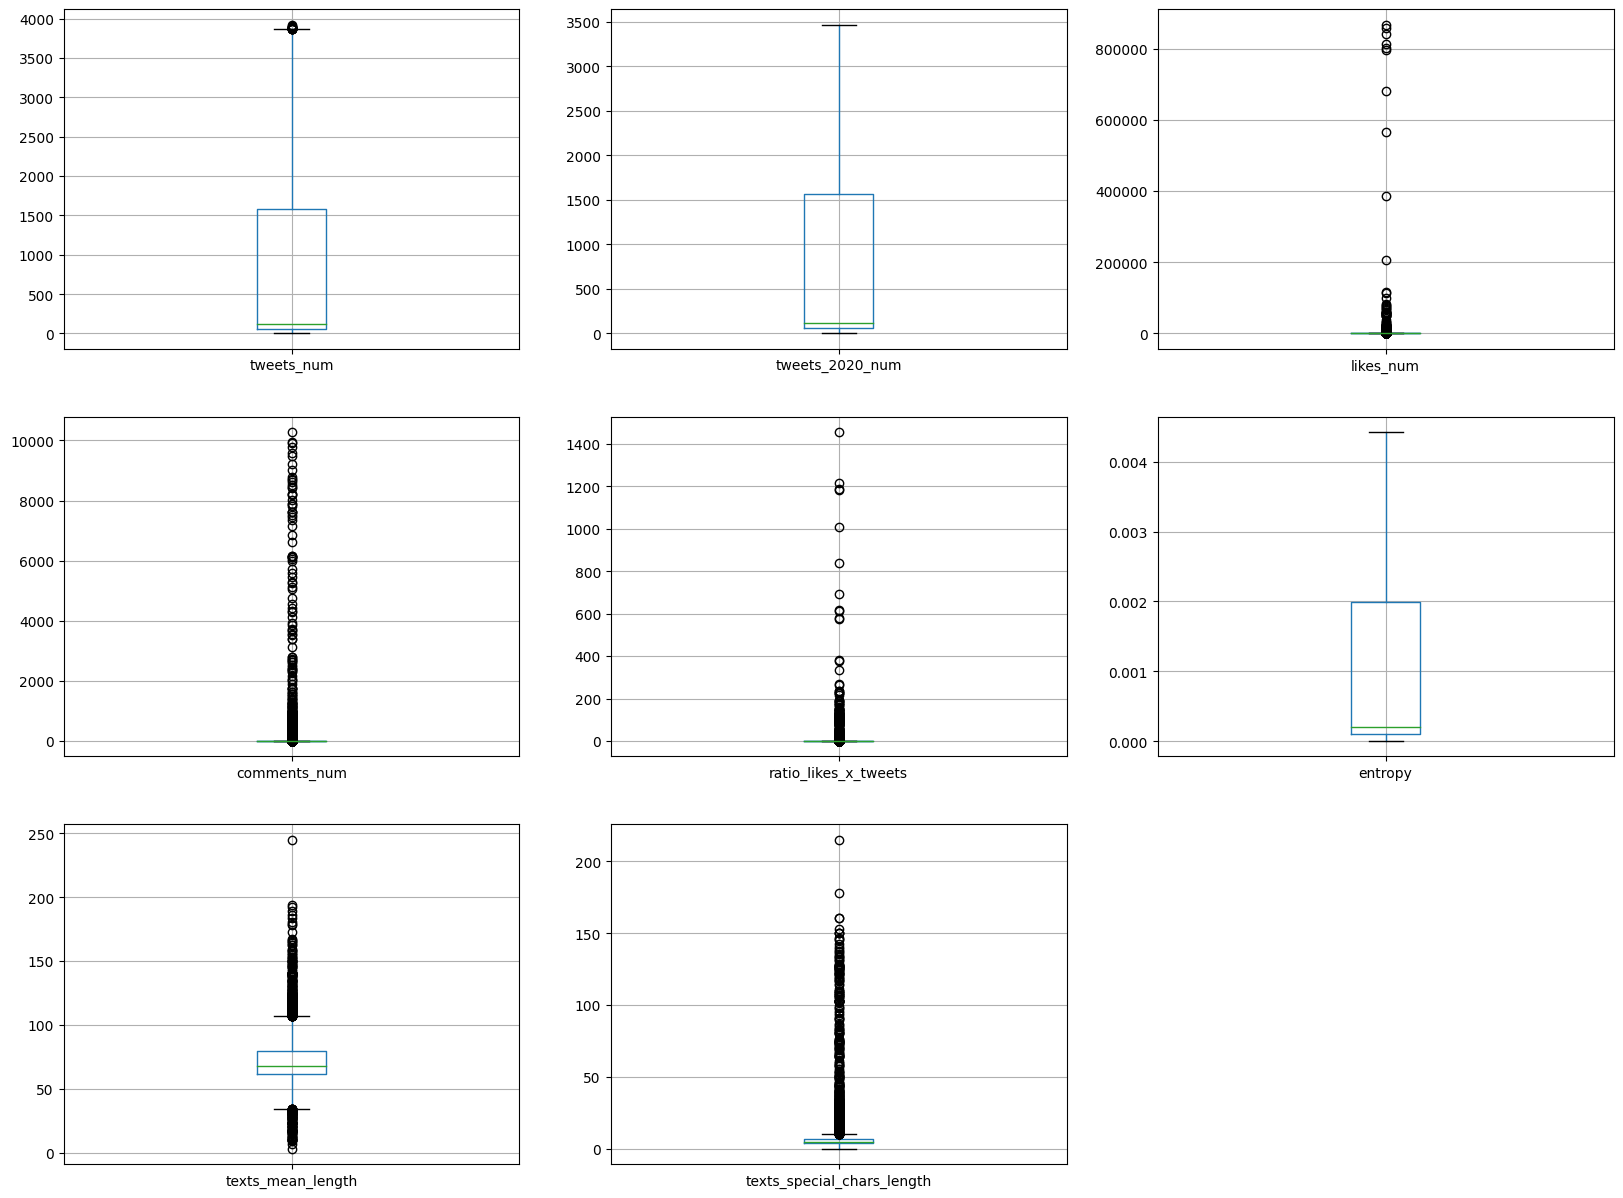

In [15]:
def boxplot_tweets_newfeatures_show():
    configs = [
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['tweets_num']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['tweets_2020_num']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['likes_num']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['comments_num']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['ratio_likes_x_tweets']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['entropy']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['texts_mean_length']
        },
        {
            'type': 'boxplot',
            'df': users,
            'columns': ['texts_special_chars_length']
        },
    ]

    build_grid_plot(configs=configs)

boxplot_tweets_newfeatures_show()

Here are printed the percentage of outliers over and below the two box-plot whiskers for each new numerical attribute of users dataset.

In [16]:
for col in ['tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'ratio_likes_x_tweets', 'entropy', 'texts_mean_length', 'texts_special_chars_length']:
    Q1 = np.quantile(users[col], 0.25)
    Q3 = np.quantile(users[col], 0.75)
    IQR = Q3 - Q1
    superior_whisker = Q3 + 1.5 * IQR
    outliers_perc_sup = len(users[users[col] > superior_whisker]) / len(users) * 100
    inferior_whisker = Q1 - 1.5 * IQR
    outliers_perc_inf = len(users[users[col] < inferior_whisker]) / len(users) * 100
    outliers_perc = outliers_perc_sup + outliers_perc_inf
    lg.info(f'{outliers_perc} % of column {col} are over superior whisker ({superior_whisker}) and below inferior one ({inferior_whisker})')

2022-11-05 11:00:03,056 - root - INFO - 0.13903371567605144 % of column tweets_num are over superior whisker (3866.0) and below inferior one (-2224.0)
2022-11-05 11:00:03,060 - root - INFO - 0.0 % of column tweets_2020_num are over superior whisker (3829.0) and below inferior one (-2203.0)
2022-11-05 11:00:03,063 - root - INFO - 14.16405978449774 % of column likes_num are over superior whisker (908.0) and below inferior one (-540.0)
2022-11-05 11:00:03,067 - root - INFO - 18.68265554396941 % of column comments_num are over superior whisker (0.0) and below inferior one (0.0)
2022-11-05 11:00:03,070 - root - INFO - 13.755648244699339 % of column ratio_likes_x_tweets are over superior whisker (0.6335798860743429) and below inferior one (-0.3405193223190267)
2022-11-05 11:00:03,073 - root - INFO - 0.0 % of column entropy are over superior whisker (0.004816236680844571) and below inferior one (-0.0027246508256134143)
2022-11-05 11:00:03,076 - root - INFO - 3.684393465415363 % of column text

### Correlation

Correlation matrix according old and new numerical values of users dataset.

In [17]:
users_num_cols = ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'entropy', 'ratio_likes_x_tweets', 'texts_mean_length', 'texts_special_chars_length']
corr = users.corr(method='pearson', numeric_only=True).loc[users_num_cols, users_num_cols]
corr.style.background_gradient(cmap='coolwarm')

,statuses_count,bot,tweets_num,tweets_2020_num,likes_num,comments_num,entropy,ratio_likes_x_tweets,texts_mean_length,texts_special_chars_length
statuses_count,1.000000,-0.255156,0.514993,0.510962,0.008561,0.042398,0.506627,-0.021654,0.007745,-0.026969
bot,-0.255156,1.000000,-0.278936,-0.274364,0.006216,-0.024049,-0.285436,0.027789,0.081917,0.027101
tweets_num,0.514993,-0.278936,1.000000,0.998513,0.033435,0.112941,0.999022,-0.038873,0.161705,-0.080862
tweets_2020_num,0.510962,-0.274364,0.998513,1.000000,0.033835,0.115102,0.997837,-0.038735,0.161604,-0.081330
likes_num,0.008561,0.006216,0.033435,0.033835,1.000000,0.023964,0.035544,0.797510,0.079549,0.014484
comments_num,0.042398,-0.024049,0.112941,0.115102,0.023964,1.000000,0.112937,0.025358,0.035409,0.021064
entropy,0.506627,-0.285436,0.999022,0.997837,0.035544,0.112937,1.000000,-0.038837,0.170198,-0.083000
ratio_likes_x_tweets,-0.021654,0.027789,-0.038873,-0.038735,0.797510,0.025358,-0.038837,1.000000,0.084748,0.066087
texts_mean_length,0.007745,0.081917,0.161705,0.161604,0.079549,0.035409,0.170198,0.084748,1.000000,0.480417
texts_special_chars_length,-0.026969,0.027101,-0.080862,-0.081330,0.014484,0.021064,-0.083000,0.066087,0.480417,1.000000


In [18]:
# save users_total as pickle
store_preprocessed_dataset(step_name="users_total", file_name="users.pickle", df=users)